# Covid-19 Tracker for Spain
https://cnecovid.isciii.es/covid19/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcs import *

## Data Gathering & Cleaning

Read Dataset

In [2]:
data = get_data()
data.head()

,province,sex,age,date,cases,hospitalizations,icu,deaths
12720,A,H,0-9,2020-01-09,0,0,0,0
12721,A,H,10-19,2020-01-09,0,0,0,0
12722,A,H,20-29,2020-01-09,0,0,0,0
12723,A,H,30-39,2020-01-09,0,0,0,0
12724,A,H,40-49,2020-01-09,0,0,0,0


In [3]:
data = get_waves(get_sma7,data)
data.head()

,province,sex,age,date,cases,hospitalizations,icu,deaths,wave
12720,A,H,0-9,2020-01-09,0,0,0,0,1
12721,A,H,10-19,2020-01-09,0,0,0,0,1
12722,A,H,20-29,2020-01-09,0,0,0,0,1
12723,A,H,30-39,2020-01-09,0,0,0,0,1
12724,A,H,40-49,2020-01-09,0,0,0,0,1


In [4]:
data.tail()

,province,sex,age,date,cases,hospitalizations,icu,deaths,wave
1367395,ZA,NC,50-59,2022-05-09,0,0,0,0,6
1367396,ZA,NC,60-69,2022-05-09,0,0,0,0,6
1367397,ZA,NC,70-79,2022-05-09,0,0,0,0,6
1367398,ZA,NC,80+,2022-05-09,0,0,0,0,6
1367399,ZA,NC,NC,2022-05-09,0,0,0,0,6


Export to .csv

In [5]:
data.to_csv('../data/covid_19_spain.csv', sep=';', index = False)

Group by date and smooth

In [7]:
by_date = get_sma7(data, by='wave')

Divide time domain in waves

### Has the mortality remained constant over time?

### Has the ratio between ages remained constant over time?

### 3. Create waves variable. 
- **input**: covid
- **output**: totals_bydate

Lastly we get the wave dates be getting the minimums between peaks. For the first wave well use hospitalizations since there were no cases registered

In [59]:
aux_mask = totals_bydate.date.between('2020-04','2020-10')
idx_2nd = totals_bydate.loc[aux_mask,'hospitalizations_sma7'].idxmin()
start_2nd = totals_bydate.iloc[idx_2nd]['date']

In [60]:
aux_mask = totals_bydate.date.between('2020-11','2021-02')
idx_3rd = totals_bydate.loc[aux_mask,'cases_sma7'].idxmin()
start_3rd = totals_bydate.iloc[idx_3rd]['date']

In [61]:
aux_mask = totals_bydate.date.between('2021-02','2021-05')
idx_4th = totals_bydate.loc[aux_mask,'cases_sma7'].idxmin()
start_4th = totals_bydate.iloc[idx_4th]['date']

In [62]:
aux_mask = totals_bydate.date.between('2021-05','2021-08')
idx_5th = totals_bydate.loc[aux_mask,'cases_sma7'].idxmin()
start_5th = totals_bydate.iloc[idx_5th]['date']

In [63]:
aux_mask = totals_bydate.date.between('2021-08','2021-12')
idx_6th = totals_bydate.loc[aux_mask,'cases_sma7'].idxmin()
start_6th = totals_bydate.iloc[idx_6th]['date']

In [64]:
bins = [covid.date.min(), start_2nd, start_3rd, start_4th, start_5th, start_6th, covid.date.max()]
labels = [1,2,3,4,5,6]

In [65]:
covid['wave'] = pd.cut(covid.date, bins = bins, labels = labels, include_lowest = True)
totals_bydate['wave'] = pd.cut(totals_bydate.date, bins = bins, labels = labels, include_lowest = True)

### 4. Cumulative everything by wave
- **input**: covid
- **output**: totals

In [66]:
totals = covid.groupby(['age','wave'])[['cases', 'hospitalizations', 'icu', 'deaths']].sum()

In [67]:
cumulative_totals_bywave = totals.groupby(level=1).cumsum().reset_index()
cumulative_totals_byage = totals.groupby(level=0).cumsum().reset_index()

In [68]:
cumulative_pct_wave = cumulative_totals_bywave[['cases', 'hospitalizations', 'icu', 'deaths']]/cumulative_totals_bywave.groupby('wave')[['cases', 'hospitalizations', 'icu', 'deaths']].transform(np.max) * 100
cumulative_pct_wave = cumulative_pct_wave.round(decimals = 2)

In [69]:
totals = totals.reset_index().merge(cumulative_totals_bywave, how='inner', on=['age', 'wave'], suffixes = ['', '_cuwave'])

In [70]:
totals = pd.concat([totals, cumulative_pct_wave.add_suffix('_cuwave_pct')], axis=1)

In [71]:
totals.head(8)

,age,wave,cases,hospitalizations,icu,deaths,cases_cuwave,hospitalizations_cuwave,icu_cuwave,deaths_cuwave,cases_cuwave_pct,hospitalizations_cuwave_pct,icu_cuwave_pct,deaths_cuwave_pct
0,0-9,1,1382,353,53,5,1382,353,53,5,0.55,0.32,0.57,0.02
1,0-9,2,105285,1151,38,0,105285,1151,38,0,7.08,0.98,0.37,0.00
2,0-9,3,110828,576,31,5,110828,576,31,5,7.58,0.52,0.28,0.02
3,0-9,4,46300,347,25,3,46300,347,25,3,8.24,0.77,0.44,0.06
4,0-9,5,92361,831,32,4,92361,831,32,4,7.65,1.76,0.68,0.07
5,0-9,6,53534,220,9,6,53534,220,9,6,12.38,1.81,0.68,0.45
6,10-19,1,2670,411,47,6,4052,764,100,11,1.61,0.70,1.07,0.04
7,10-19,2,172896,1214,56,8,278181,2365,94,8,18.69,2.01,0.90,0.04


### 5. Ratios
- **inplace**: totals

In [72]:
totals['pct_hosp_cases'] = 100*totals.hospitalizations/totals.cases
totals['pct_icu_hosp'] = 100*totals.icu/totals.hospitalizations
totals['pct_icu_cases'] = 100*totals.icu/totals.cases
totals['pct_deaths_hosp'] = 100*totals.deaths/totals.hospitalizations
totals['pct_deaths_icu'] = 100*totals.deaths/totals.icu
totals['pct_deaths_cases'] = 100*totals.deaths/totals.cases

In [73]:
to_calculate = ['cases', 'hospitalizations', 'icu', 'deaths']
totals_pct = totals.loc[:, to_calculate]/totals.groupby('wave')[to_calculate].transform(sum)
totals = pd.concat([totals, totals_pct.add_suffix('_wave_pct')], axis=1)

In [74]:
totals.head()

,age,wave,cases,hospitalizations,icu,deaths,cases_cuwave,hospitalizations_cuwave,icu_cuwave,deaths_cuwave,...,pct_hosp_cases,pct_icu_hosp,pct_icu_cases,pct_deaths_hosp,pct_deaths_icu,pct_deaths_cases,cases_wave_pct,hospitalizations_wave_pct,icu_wave_pct,deaths_wave_pct
0,0-9,1,1382,353,53,5,1382,353,53,5,...,25.542692,15.014164,3.835022,1.416431,9.433962,0.361795,0.005501,0.003228,0.005667,0.000169
1,0-9,2,105285,1151,38,0,105285,1151,38,0,...,1.093223,3.301477,0.036093,0.000000,0.000000,0.000000,0.070753,0.009764,0.003651,0.000000
2,0-9,3,110828,576,31,5,110828,576,31,5,...,0.519724,5.381944,0.027971,0.868056,16.129032,0.004511,0.075789,0.005187,0.002787,0.000195
3,0-9,4,46300,347,25,3,46300,347,25,3,...,0.749460,7.204611,0.053996,0.864553,12.000000,0.006479,0.082445,0.007732,0.004413,0.000564
4,0-9,5,92361,831,32,4,92361,831,32,4,...,0.899730,3.850782,0.034647,0.481348,12.500000,0.004331,0.076515,0.017603,0.006811,0.000697


### 6. Multiindex Dataframe of increases
- **input**: totals
- **output**: df_increases

init ages dict

In [75]:
dict_ages = {}
for age in totals.age.unique():
    dict_ages[age] = {}

populate the dict using np broadcasting

In [77]:
for age in totals.age.unique():
    index = [1,2,3,4,5,6]
    columns =[1,2,3,4,5,6]
    mask = totals.age == age
    # cases
    cases = totals.loc[mask, 'cases']
    dict_ages[age]['cases'] = pd.DataFrame(((np.subtract.outer(*[cases.values]*2)).T / cases.values[:,None]).T*100, index = index, columns=columns)
    # hospitalizations
    hospitalizations = totals.loc[mask, 'hospitalizations']
    dict_ages[age]['hospitalizations'] = pd.DataFrame(((np.subtract.outer(*[hospitalizations.values]*2)).T / hospitalizations.values[:,None]).T*100, index = index, columns=columns)
    # icu
    icu = totals.loc[mask, 'icu']
    dict_ages[age]['icu'] = pd.DataFrame(((np.subtract.outer(*[icu.values]*2)).T / icu.values[:,None]).T*100, index = index, columns=columns)
    # deaths
    deaths = totals.loc[mask, 'deaths']
    dict_ages[age]['deaths'] = pd.DataFrame(((np.subtract.outer(*[deaths.values]*2)).T / deaths.values[:,None]).T*100, index = index, columns=columns)
    # pct hosp/cases
    pct_hosp_cases = totals.loc[mask, 'pct_hosp_cases']
    dict_ages[age]['pct_hosp_cases'] = pd.DataFrame(((np.subtract.outer(*[pct_hosp_cases.values]*2)).T / pct_hosp_cases.values[:,None]), index = index, columns=columns)
    # pct icu/hosp
    pct_icu_hosp = totals.loc[mask, 'pct_icu_hosp']
    dict_ages[age]['pct_icu_hosp'] = pd.DataFrame(((np.subtract.outer(*[pct_icu_hosp.values]*2)).T / pct_icu_hosp.values[:,None]), index = index, columns=columns)

C:\Users\fpala\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\fpala\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


reform to a multtindex of dataframes

In [78]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in dict_ages.items() for innerKey, values in innerDict.items()}
df_increases = pd.concat(reform.values(), keys=reform.keys())
df_increases.replace([np.inf, -np.inf], np.nan, inplace=True)

In [79]:
idx = df_increases.index
idx.set_names(['age', 'observation', 'wave'], inplace=True)
df_increases.columns.set_names('wave', inplace=True)

In [80]:
df_increases.head(10)

wave                                 1          2          3           4  \
age observation      wave                                                  
0-9 cases            1        0.000000 -98.687372 -98.753023  -97.015119   
                     2     7518.306802   0.000000  -5.001444  127.397408   
                     3     7919.392185   5.264758   0.000000  139.369330   
                     4     3250.217077 -56.024125 -58.223554    0.000000   
                     5     6583.140376 -12.275253 -16.662757   99.483801   
                     6     3773.661360 -49.153251 -51.696322   15.624190   
    hospitalizations 1        0.000000 -69.331017 -38.715278    1.729107   
                     2      226.062323   0.000000  99.826389  231.700288   
                     3       63.172805 -49.956560   0.000000   65.994236   
                     4       -1.699717 -69.852302 -39.756944    0.000000   

wave                               5           6  
age observation      wave                         
0-9 cases            1    -98.503697  -97.418463  
                     2     13.992919   96.669406  
                     3     19.994370  107.023574  
                     4    -49.870616  -13.512908  
                     5      0.000000   72.527739  
                     6    -42.038306    0.000000  
    hospitalizations 1    -57.521059   60.454545  
                     2     38.507822  423.181818  
                     3    -30.685921  161.818182  
                     4    -58.243081   57.727273

----

## 1st Dashboard. Time series visualization hue Wave
1. 7-day SMA of cases, hue wave
1. 7-day SMA of hospitalizations, hue wave
1. 7-day SMA of icu, hue wave
1. 7-day SMA of deaths, hue wave

In [81]:
sns.set_palette('colorblind')
plt.rcParams["axes.grid.axis"] ="y"
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.titlesize"] = "16"
sns.set_style("whitegrid", {"grid.alpha": 1, "grid.linewidth": 1, "grid.linestyle": "--"})

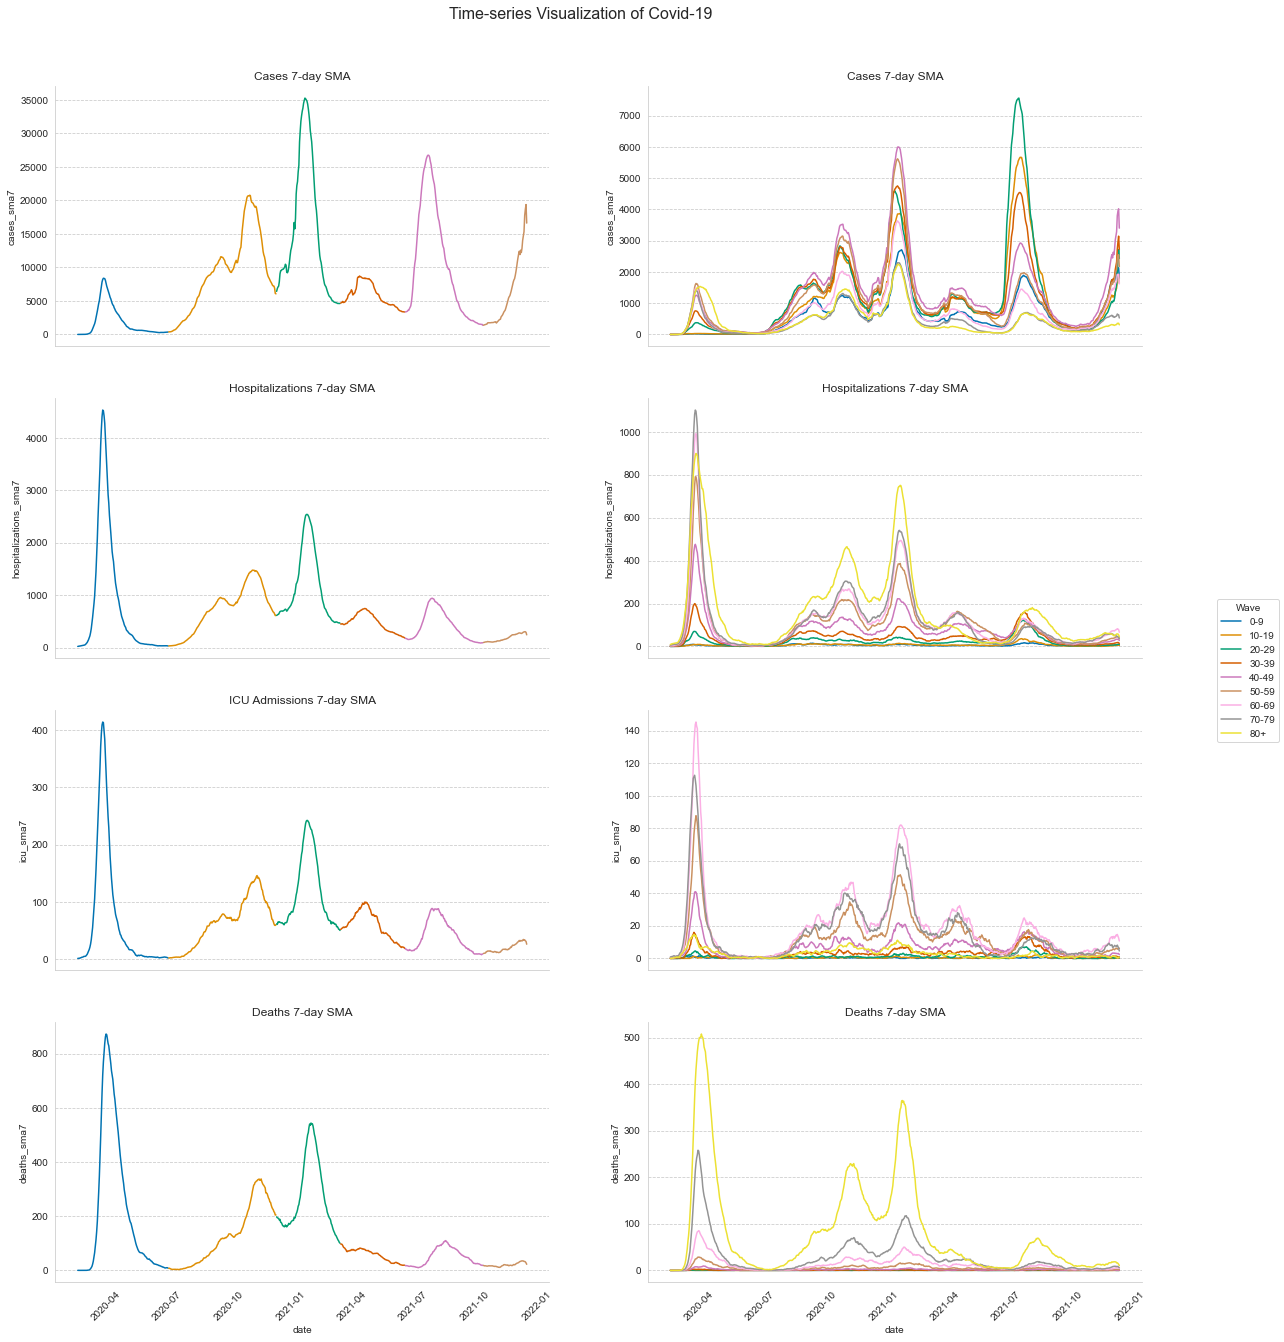

In [82]:
size_unit=np.array([1.77,2])

# create figure
fig, axes = plt.subplots(4, 2, figsize = 11*size_unit, sharex=True)
fig.suptitle('Time-series Visualization of Covid-19', y=0.93)

# plot axes and set titles
sns.lineplot(ax = axes[0,0], data=totals_bydate, x='date', y='cases_sma7', hue = 'wave')
axes[0,0].set_title('Cases 7-day SMA')
sns.lineplot(ax = axes[1,0], data=totals_bydate, x='date', y='hospitalizations_sma7', hue = 'wave')
axes[1,0].set_title('Hospitalizations 7-day SMA')
sns.lineplot(ax = axes[2,0], data=totals_bydate, x='date', y='icu_sma7', hue='wave')
axes[2,0].set_title('ICU Admissions 7-day SMA')
sns.lineplot(ax = axes[3,0], data=totals_bydate, x='date', y='deaths_sma7', hue='wave')
axes[3,0].set_title('Deaths 7-day SMA')

# plot axes and set titles
sns.lineplot(ax = axes[0,1], x='date', y='cases_sma7', data = covid, hue='age')
axes[0,1].set_title('Cases 7-day SMA')
sns.lineplot(ax = axes[1,1], x='date', y='hospitalizations_sma7', data = covid, hue='age')
axes[1,1].set_title('Hospitalizations 7-day SMA')
sns.lineplot(ax = axes[2,1], x='date', y='icu_sma7', data = covid, hue='age')
axes[2,0].set_title('ICU Admissions 7-day SMA')
sns.lineplot(ax = axes[3,1], x='date', y='deaths_sma7', data = covid, hue='age')
axes[3,1].set_title('Deaths 7-day SMA')

# All axes styling
for ax in axes.flat:
    # remove legend
    ax.get_legend().remove()
    # rotate x_ticks 
    ax.tick_params(axis='x', rotation=45)
        
#styling
legend_handles, legend_labels = axes[1,1].get_legend_handles_labels()
fig.legend(legend_handles, legend_labels, loc='center right', title = 'Wave')
sns.despine()

plt.savefig('./fig/time_series.png', bbox_inches = 'tight')

In [83]:
# wave duration
totals_bydate.groupby('wave').date.count()

wave
1    141
2    160
3     95
4     96
5    116
6     65
Name: date, dtype: int64

In [84]:
totals_bydate.iloc[totals_bydate.groupby('wave').cases_sma7.idxmax().values]

,date,cases,hospitalizations,icu,deaths,cases_sma7,hospitalizations_sma7,icu_sma7,deaths_sma7,wave
44,2020-03-28,6949,3354,328,838,8382.857143,4517.428571,412.714286,769.571429,1
261,2020-10-31,16077,1243,116,269,20766.000000,1425.000000,126.714286,240.285714,2
343,2021-01-21,40738,2767,266,490,35266.000000,2458.285714,229.000000,424.714286,3
424,2021-04-12,9024,846,96,95,8718.714286,693.428571,90.142857,81.857143,4
526,2021-07-23,29968,1036,84,44,26753.285714,861.000000,72.714286,36.428571,5
671,2021-12-15,16292,153,27,7,19376.857143,289.285714,31.285714,27.571429,6


In [85]:
totals_bydate.iloc[totals_bydate.groupby('wave').hospitalizations_sma7.idxmax().values]

,date,cases,hospitalizations,icu,deaths,cases_sma7,hospitalizations_sma7,icu_sma7,deaths_sma7,wave
43,2020-03-27,8964,4744,365,903,8201.857143,4531.000000,413.714286,721.714286,1
265,2020-11-04,24094,1612,134,355,19665.000000,1476.857143,133.428571,290.857143,2
346,2021-01-24,17303,1910,186,518,34813.142857,2540.285714,242.285714,483.857143,3
432,2021-04-20,10770,798,119,80,8426.857143,746.000000,100.000000,77.571429,4
532,2021-07-29,25482,947,83,67,23914.000000,941.285714,88.714286,62.857143,5
669,2021-12-13,24569,307,30,41,17735.285714,302.428571,34.000000,32.857143,6


In [86]:
totals_bydate.iloc[totals_bydate.groupby('wave').icu_sma7.idxmax().values]

,date,cases,hospitalizations,icu,deaths,cases_sma7,hospitalizations_sma7,icu_sma7,deaths_sma7,wave
43,2020-03-27,8964,4744,365,903,8201.857143,4531.000000,413.714286,721.714286,1
272,2020-11-11,19959,1524,144,362,18339.285714,1448.714286,146.000000,331.000000,2
346,2021-01-24,17303,1910,186,518,34813.142857,2540.285714,242.285714,483.857143,3
432,2021-04-20,10770,798,119,80,8426.857143,746.000000,100.000000,77.571429,4
532,2021-07-29,25482,947,83,67,23914.000000,941.285714,88.714286,62.857143,5
667,2021-12-11,15343,336,36,30,14696.428571,294.285714,34.714286,34.714286,6


In [87]:
totals_bydate.iloc[totals_bydate.groupby('wave').deaths_sma7.idxmax().values]

,date,cases,hospitalizations,icu,deaths,cases_sma7,hospitalizations_sma7,icu_sma7,deaths_sma7,wave
48,2020-04-01,6936,3161,267,891,7635.857143,3716.571429,327.142857,873.142857,1
278,2020-11-17,15850,1363,122,375,14764.285714,1301.571429,128.000000,337.714286,2
352,2021-01-30,18133,1770,197,512,29555.000000,2356.142857,226.714286,544.285714,3
396,2021-03-15,5574,487,61,99,4673.142857,450.571429,52.142857,97.714286,4
552,2021-08-18,12557,614,61,103,10884.428571,614.142857,66.285714,109.714286,5
665,2021-12-09,19490,325,34,36,12851.000000,274.142857,32.000000,35.142857,6


|                                      | First Wave      | Second Wave | Third Wave   | Fourth Wave | Fifth Wave   | 
| ------------------------------------ | --------------- | ----------- | ------------ | ----------- | ------------ |
| Duration (days)                      | 141             | 160         | 95           | 96          | 129          |
| Peak Cases (SMA7)                    | Unreliable      | 20771       | 35252        | 8716        | 26736        |
| Peak Cases Date                      | Unreliable      | 2020-10-31  | 2021-01-01   | 2021-04-12  | 2021-07-23   |
| Peak Hospitalizations (SMA7)         | 4530            | 1472        | 2529         | 724         | 941          |
| Peak Hospitalizations Date           | 2020-03-27      | 2020-11-04  | 2021-01-24   | 2021-04-20  | 2021-07-29   |
| Peak ICU (SMA7)                      | 413             | 145         | 241          | 93          | 87           |
| Peak ICU Date                        | 2020-03-27      | 2020-11-11  | 2021-01-24   | 2021-04-20  | 2021-07-29   |
| Peak Deaths (SMA7)                   | 873             | 337         | 544          | 97          | 107          |
| Peak Deaths Date                     | 2020-04-01      | 2020-11-17  | 2021-01-30   | 2021-03-15  | 2021-08-18   |

'infering' peak cases for the first wave from other peak values

using cases/hosp ratio

In [88]:
a = 20771*4530/1472

In [89]:
b = 35252*4530/2529

In [90]:
c = 8716*4530/724

In [91]:
(a+b+c)/3

60533.6562833805

using cases/icu

## 2nd Dashboard

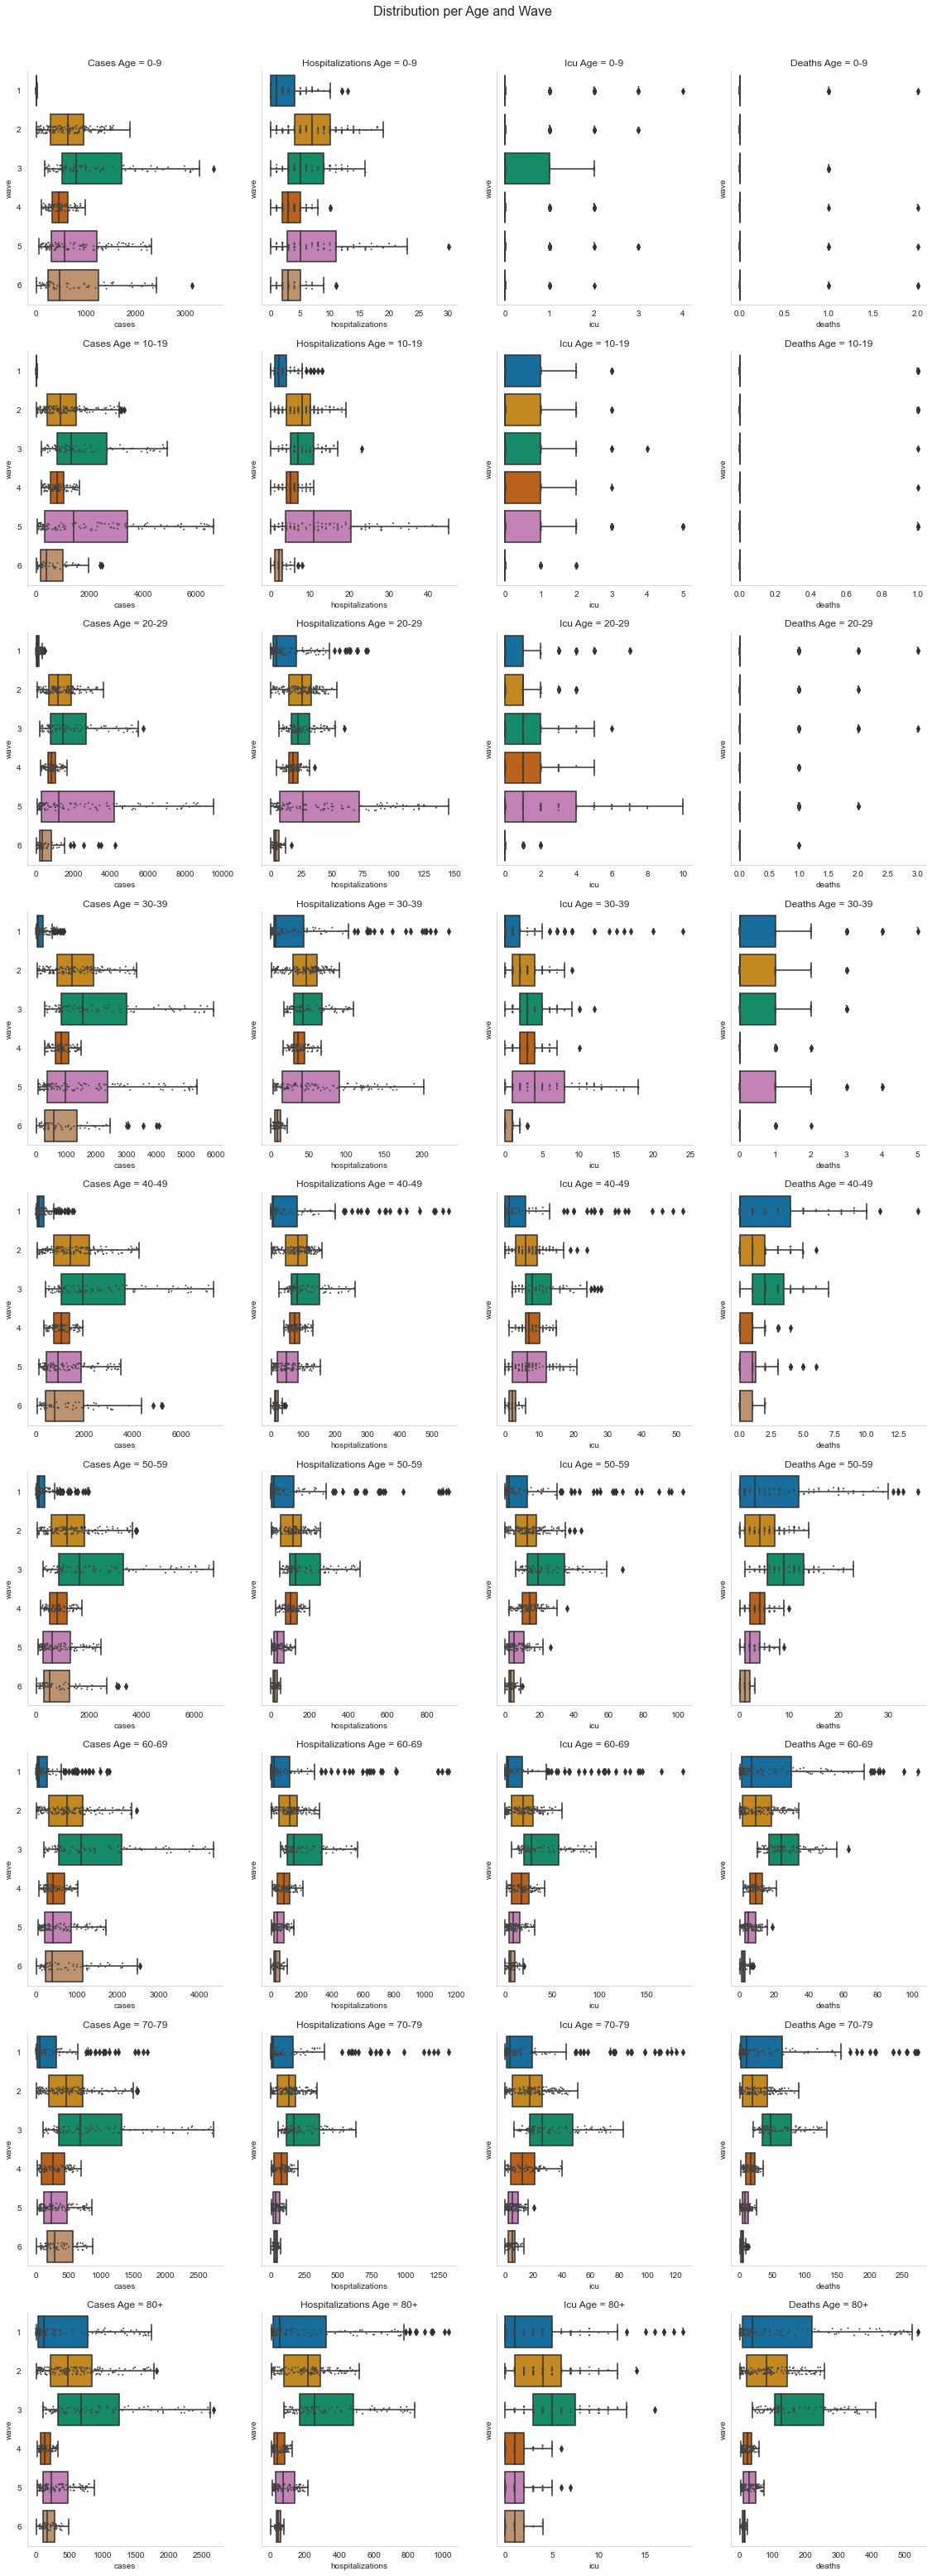

In [92]:
size_unit=np.array([1.77,5])
sns.set_palette('colorblind')

rows = covid.age.nunique()

# create figure
fig, axes = plt.subplots(rows, 4, figsize = 11*size_unit, sharey = True)
fig.suptitle('Distribution per Age and Wave', y=0.90)

for i,age in enumerate(covid.age.unique()):
    age_mask = covid.age == age
    for j,variable in enumerate(['cases', 'hospitalizations', 'icu', 'deaths']):
        sns.boxplot(data = covid.loc[age_mask, :], y='wave', x=variable, ax=axes[i,j], orient = 'h')
        sns.stripplot(data = covid.loc[age_mask, :], y='wave', x=variable, ax=axes[i,j], color = '.26', size = 2, orient='h')
        axes[i,j].set_title('{} Age = {}'.format(variable.capitalize(),age))
    
sns.despine()

plt.savefig('./fig/distributions_boxplot.png', bbox_inches = 'tight')

## 3rd Dashboard. Cumulative Visualizations

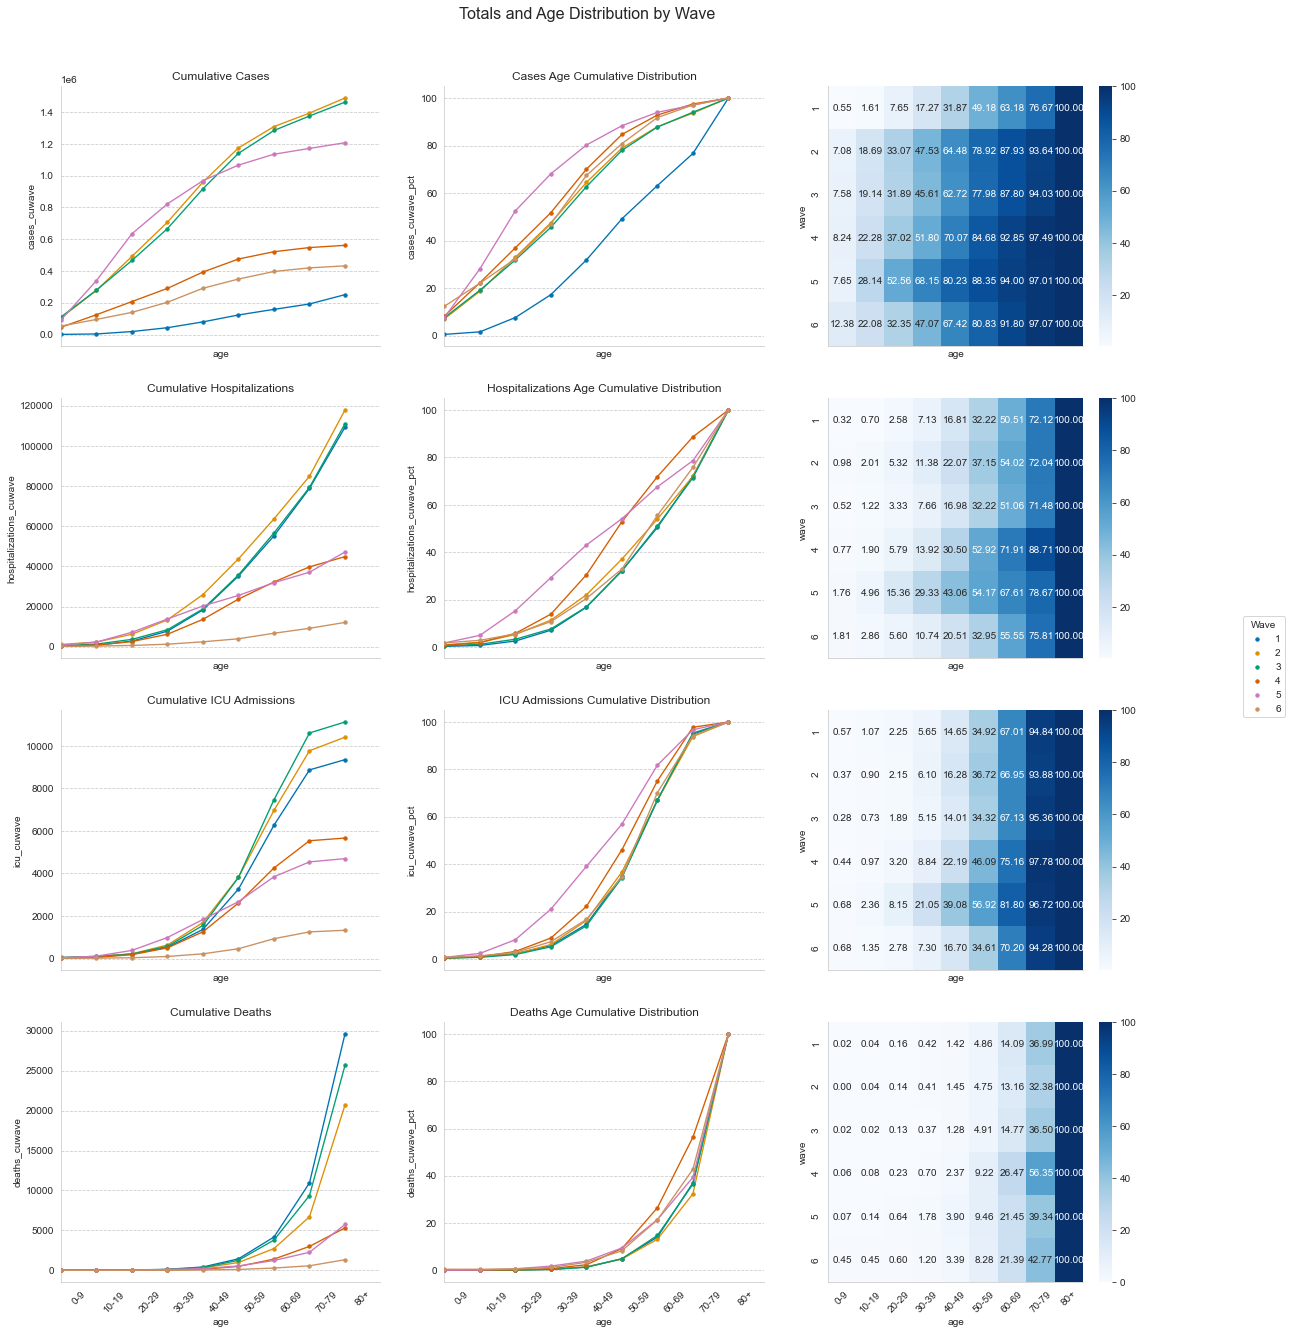

In [93]:
size_unit=np.array([1.77,2])
sns.set_palette('colorblind')

# create figure
fig, axes = plt.subplots(4, 3, figsize = 11*size_unit, sharex=True)
fig.suptitle('Totals and Age Distribution by Wave', y=0.93)

# plot axes and set titles
sns.pointplot(ax = axes[0,0], data=totals, x='age', y='cases_cuwave', hue = 'wave', scale = 0.5)
axes[0,0].set_title('Cumulative Cases')
sns.pointplot(ax = axes[0,1], data=totals, x='age', y='cases_cuwave_pct', hue = 'wave', scale = 0.5)
axes[0,1].set_title('Cases Age Cumulative Distribution')
sns.heatmap(ax = axes[0,2], data =totals.pivot('wave', 'age', 'cases_cuwave_pct'), cmap='Blues', annot=True, fmt=".2f")


sns.pointplot(ax = axes[1,0], data=totals, x='age', y='hospitalizations_cuwave', hue = 'wave', scale = 0.5)
axes[1,0].set_title('Cumulative Hospitalizations')
sns.pointplot(ax = axes[1,1], data=totals, x='age', y='hospitalizations_cuwave_pct', hue = 'wave', scale = 0.5)
axes[1,1].set_title('Hospitalizations Age Cumulative Distribution')
sns.heatmap(ax = axes[1,2], data =totals.pivot('wave', 'age', 'hospitalizations_cuwave_pct'), cmap='Blues', annot=True, fmt=".2f")

sns.pointplot(ax = axes[2,0], data=totals, x='age', y='icu_cuwave', hue = 'wave', scale = 0.5)
axes[2,0].set_title('Cumulative ICU Admissions')
sns.pointplot(ax = axes[2,1], data=totals, x='age', y='icu_cuwave_pct', hue = 'wave', scale = 0.5)
axes[2,1].set_title('ICU Admissions Cumulative Distribution')
sns.heatmap(ax = axes[2,2], data =totals.pivot('wave', 'age', 'icu_cuwave_pct'), cmap='Blues', annot=True, fmt=".2f")

sns.pointplot(ax = axes[3,0], data=totals, x='age', y='deaths_cuwave', hue = 'wave', scale = 0.5)
axes[3,0].set_title('Cumulative Deaths')
sns.pointplot(ax = axes[3,1], data=totals, x='age', y='deaths_cuwave_pct', hue = 'wave', scale = 0.5)
axes[3,1].set_title('Deaths Age Cumulative Distribution')
sns.heatmap(ax = axes[3,2], data =totals.pivot('wave', 'age', 'deaths_cuwave_pct'), cmap='Blues', annot=True, fmt=".2f")


# All axes styling
for ax in axes.flat:
    # rotate x_ticks 
    ax.tick_params(axis='x', rotation=45)

for ax in axes[:, :2].flat:
    ax.get_legend().remove()

#styling
sns.despine()
legend_handles, legend_labels = axes[1,1].get_legend_handles_labels()
fig.legend(legend_handles, legend_labels, loc='center right', title = 'Wave')

plt.savefig('./fig/totals_cumulative.png', bbox_inches = 'tight')

## 4th Dashboard Heatmaps

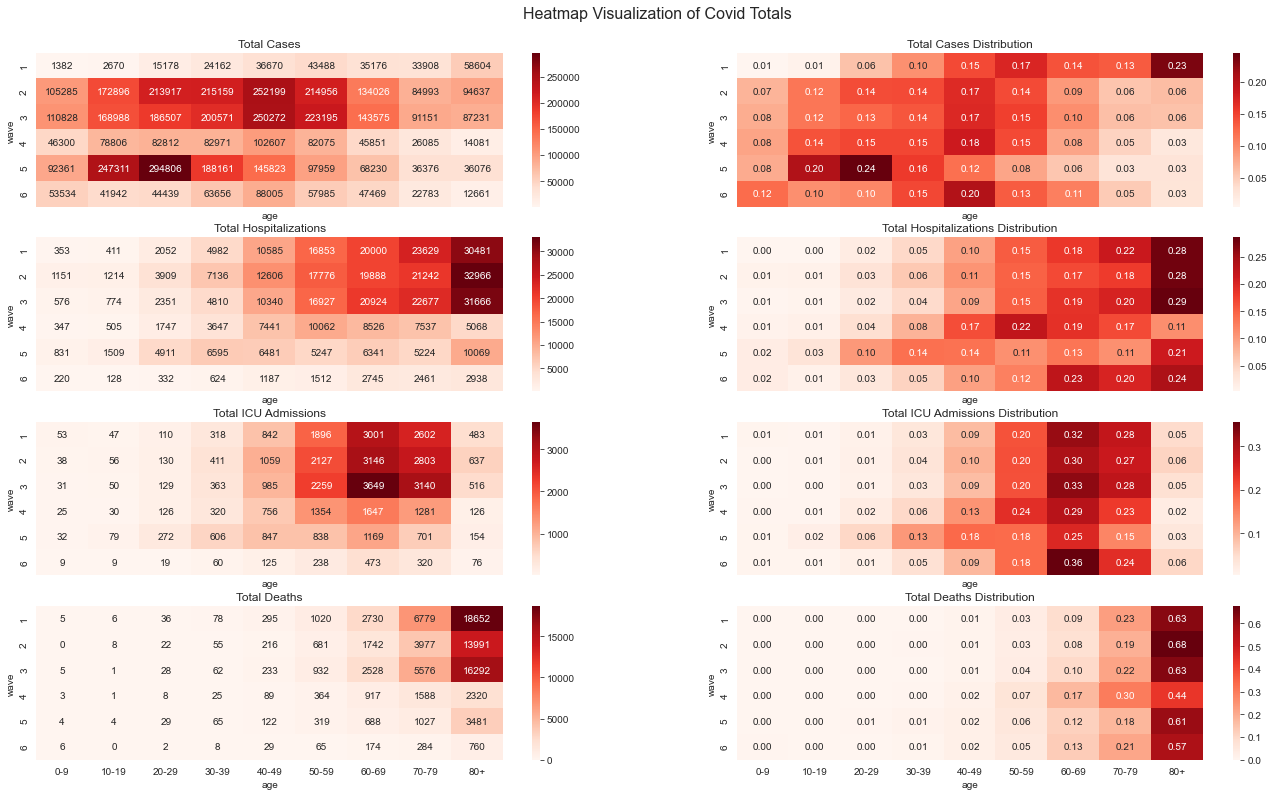

In [94]:
size_unit=np.array([1.77, 1])

# create figure
fig, axes = plt.subplots(4, 2, figsize = 13*size_unit, sharex=True)
fig.suptitle('Heatmap Visualization of Covid Totals', y=0.93)

# plot axes and set titles
sns.heatmap(totals.pivot('wave','age','cases'), cmap='Reds', ax=axes[0,0], annot=True, fmt="d")
axes[0,0].set_title('Total Cases')
sns.heatmap(totals.pivot('wave','age','cases_wave_pct'), cmap='Reds', ax=axes[0,1], annot=True, fmt=".2f")
axes[0,1].set_title('Total Cases Distribution')

sns.heatmap(totals.pivot('wave','age','hospitalizations'), cmap='Reds', ax=axes[1,0], annot=True, fmt="d")
axes[1,0].set_title('Total Hospitalizations')
sns.heatmap(totals.pivot('wave','age','hospitalizations_wave_pct'), cmap='Reds', ax=axes[1,1], annot=True, fmt=".2f")
axes[1,1].set_title('Total Hospitalizations Distribution')

sns.heatmap(totals.pivot('wave','age','icu'), cmap='Reds', ax=axes[2,0], annot=True, fmt="d")
axes[2,0].set_title('Total ICU Admissions')
sns.heatmap(totals.pivot('wave','age','icu_wave_pct'), cmap='Reds', ax=axes[2,1], annot=True, fmt=".2f")
axes[2,1].set_title('Total ICU Admissions Distribution')

sns.heatmap(totals.pivot('wave','age','deaths'), cmap='Reds', ax=axes[3,0], annot=True, fmt="d")
axes[3,0].set_title('Total Deaths')
sns.heatmap(totals.pivot('wave','age','deaths_wave_pct'), cmap='Reds', ax=axes[3,1], annot=True, fmt=".2f")
axes[3,1].set_title('Total Deaths Distribution')

plt.savefig('./fig/totals_heatmap.png', bbox_inches = 'tight')

## 5th Dashboard. Increases

masks for referincing multiindex

In [95]:
idxmask_observation_cases = df_increases.index.get_level_values('observation') == 'cases'
idxmask_wave_notfirst = df_increases.index.get_level_values('wave') != 1
colmask_wave_notone = df_increases.columns != 1
idxmask_wave_first = df_increases.index.get_level_values('wave') == 1
colmask_wave_one = df_increases.columns == 1

In [96]:
df_increases.loc[(idxmask_observation_cases, idxmask_wave_first), :] = np.nan
df_increases.loc[(idxmask_observation_cases, idxmask_wave_notfirst), colmask_wave_one] = np.nan

In [97]:
idxmask_observation_hospitalizations = df_increases.index.get_level_values('observation') == 'hospitalizations'
idxmask_observation_icu = df_increases.index.get_level_values('observation') == 'icu'
idxmask_observation_deaths = df_increases.index.get_level_values('observation') == 'deaths'

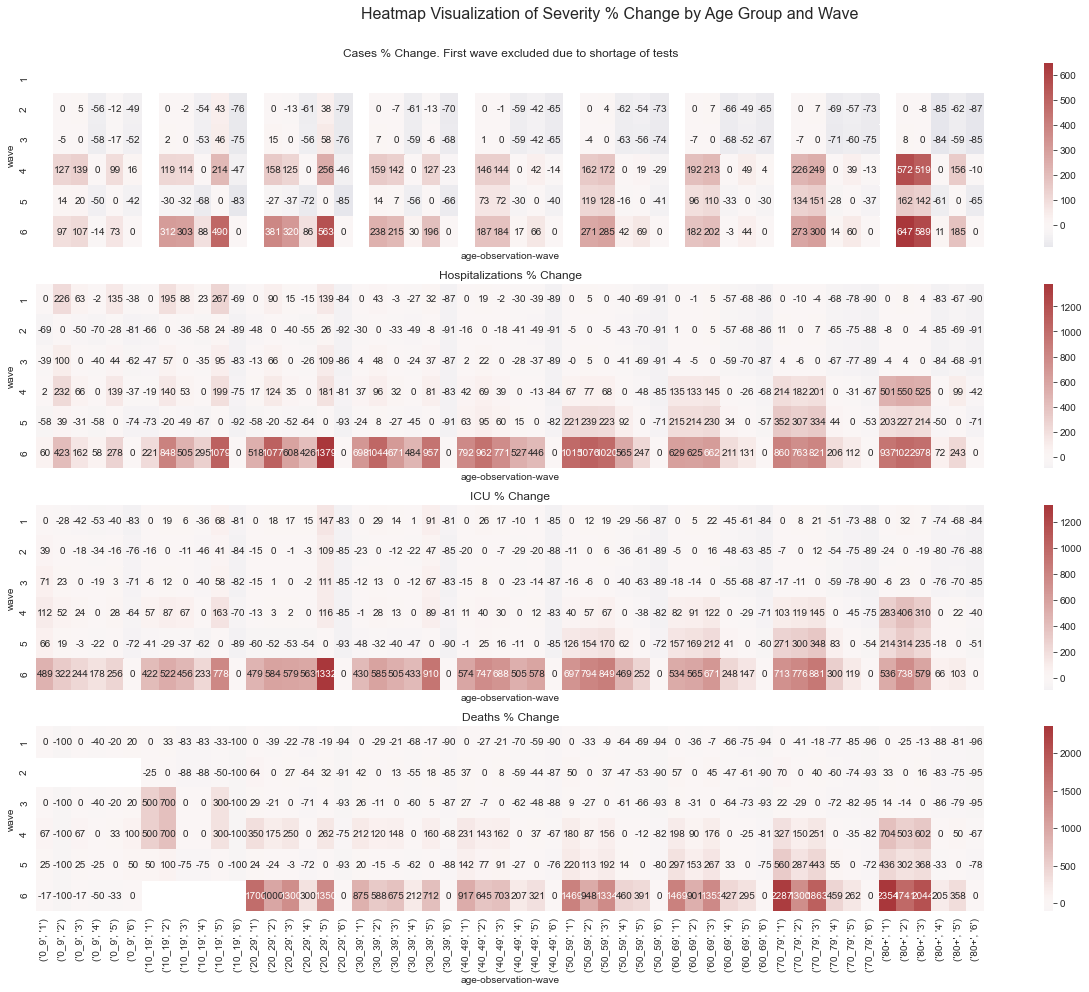

In [98]:
size_unit=np.array([1.77,1.3])

fig, axes = plt.subplots(4, 1, figsize = 12*size_unit, sharex=True)
fig.suptitle('Heatmap Visualization of Severity % Change by Age Group and Wave', y=0.93)

sns.heatmap(df_increases.loc[idxmask_observation_cases].transpose(), center = 0, cmap='vlag', annot=True, fmt = '.0f', ax=axes[0])
axes[0].set_title('Cases % Change. First wave excluded due to shortage of tests')
sns.heatmap(df_increases.loc[idxmask_observation_hospitalizations].transpose(), center = 0, cmap='vlag', annot=True, fmt = '.0f', ax=axes[1])
axes[1].set_title('Hospitalizations % Change')
sns.heatmap(df_increases.loc[idxmask_observation_icu].transpose(), center = 0, cmap='vlag', annot=True, fmt = '.0f', ax=axes[2])
axes[2].set_title('ICU % Change')
sns.heatmap(df_increases.loc[idxmask_observation_deaths].transpose(), center = 0, cmap='vlag', annot=True, fmt = '.0f', ax=axes[3])
axes[3].set_title('Deaths % Change')

for ax in axes.flat:
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [w.replace('-', '_', 1) for w in labels]
    labels = [w.replace('_deaths', '') for w in labels]
    labels = [(w.split('-')[0], w.split('-')[-1]) for w in labels]
    ax.set_xticklabels(labels)
    
plt.savefig('./fig/heatmap_pct_change.png', bbox_inches = 'tight')

#### Drafts
----

Deaths 2019

## SERIE TEMPORAL VACUNACION EDAD??
usar requests y un engine de ods para buscar constuir una funcion que construya un dataset con los datos de vacunacion

pd.read_csv('https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Informe_Comunicacion_20210819.ods')

In [ ]:
# waveday variable
covid['waveday'] = covid.groupby(['age','wave'])['date'].rank()